In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
btc = pd.read_csv("/crypto_data/bitcoin_price.csv")

In [3]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 7 columns):
Date          1655 non-null object
Open          1655 non-null float64
High          1655 non-null float64
Low           1655 non-null float64
Close         1655 non-null float64
Volume        1655 non-null object
Market Cap    1655 non-null object
dtypes: float64(4), object(3)
memory usage: 90.6+ KB


In [4]:
btc['Date'] = pd.to_datetime(btc['Date'])     
btc['date_delta'] = (btc['Date'] - btc['Date'].min())  / np.timedelta64(1,'D')

In [5]:
btc_select=btc[['date_delta','Close']]

In [6]:
btc_select.head()

,date_delta,Close
0,1654.0,7144.38
1,1653.0,7022.76
2,1652.0,7407.41
3,1651.0,7379.95
4,1650.0,7207.76


In [7]:
msk = np.random.rand(len(btc_select)) < 0.8
btc_train = btc_select[msk]
btc_test = btc_select[~msk]

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(btc_train)
btc_train = scaler.transform(btc_train)
btc_test = scaler.transform(btc_test)

In [9]:
btc_train.shape

(1329, 2)

In [10]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [11]:
def predict_prices(dates_train, prices_train, dates_test, price_test):
    dates_train=np.reshape(dates_train, (len(dates_train),1))
    dates_test=np.reshape(dates_test, (len(dates_test),1))
    svr_lin = SVR(kernel='linear', C=1e3)
    svr_poly = SVR(kernel = 'poly', C=1e3, degree=8)
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.8)
    svr_lin.fit(dates_train,prices_train)
    svr_poly.fit(dates_train,prices_train)
    svr_rbf.fit(dates_train,prices_train)
    plt.figure(figsize=(14,10))
    plt.scatter(dates_train, prices_train, color='black', label='Data')
    plt.plot(dates_train, svr_rbf.predict(dates_train), color='red', label='RBF model')
    plt.plot(dates_train, svr_lin.predict(dates_train), color='green', label='Linear model')
    plt.plot(dates_train, svr_poly.predict(dates_train), color='blue', label='Polynomial model')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.show()
    print('Lin Score:', svr_lin.score(dates_test, price_test))
    print('Poly Score:', svr_poly.score(dates_test, price_test))
    print('Rbf Score:', svr_rbf.score(dates_test, price_test))
    scores = cross_val_score(svr_poly, dates_train, prices_train, cv=6, scoring='neg_mean_squared_error')
    accuracy = metrics.r2_score(price_test, svr_poly.predict(dates_test))
    print('R-Squared Value for the Polynomial Kernel:', accuracy)
    print('Cross Validation Mean Squared Error for the Polynomial Kernel:', scores)
    return svr_poly

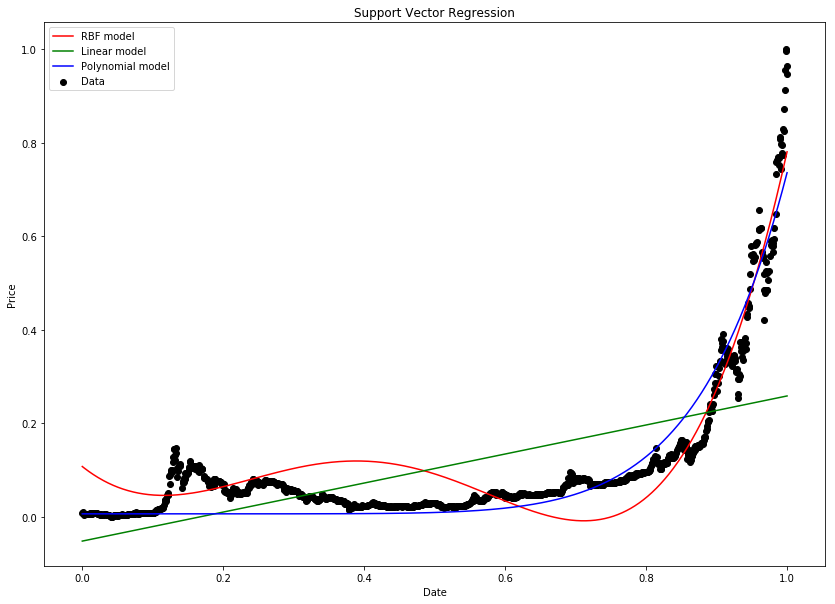

Lin Score: 0.37290336524039847
Poly Score: 0.902091120238935
Rbf Score: 0.8399414035174312
R-Squared Value for the Polynomial Kernel: 0.902091120238935
Cross Validation Mean Squared Error for the Polynomial Kernel: [-0.13461249 -0.00072289 -0.00048515 -0.00043247 -0.00320793 -0.00460232]


In [12]:
model = predict_prices(btc_train[:,0], btc_train[:,1], btc_test[:,0], btc_test[:,1])

In [13]:
transform_inp = scaler.transform([[1654.0,0.0]])
transform_inp[0,0]

1.0

In [14]:
predicted_val = model.predict(np.array(transform_inp[0,0]))
predicted_val

array([0.73633744])

In [15]:
scaler.inverse_transform([[predicted_val[0],0]])

array([[1217.90212749,   68.43      ]])